# Surface Runoff
This script uses Version 5 of the 'Streams, Outlets, Basins, and Discharge [k=1.0]' dataset (Mankoff et al., 2020) provided on the GEUS dataverse. For details regarding this dataset, please visit: https://doi.org/10.22008/FK2/XKQVL7. It should be noted that as Jakobshavn Isbrae is a marine-terminating glacier, only the 'ice' datasets are downloaded; the 'land' files are not needed. 

In [1]:
# IMPORT MODULES [freshwater_discharge environment]
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime, timedelta

In [7]:
# DEFINE THE RACMO AND MAR DATASETS
racmo_ds = xr.open_dataset('R:/JAKOBSHAVN/DATA/surface_runoff/ken_mankoff/freshwater/ice/RACMO.nc')
mar_ds = xr.open_dataset('R:/JAKOBSHAVN/DATA/surface_runoff/ken_mankoff/freshwater/ice/MAR.nc')

In [8]:
# DEFINE THE STATION_ID [OUTLET ID] FOR JAKOBSHAVN ISBRAE 
station_id = 62369
racmo_discharge_timeseries = racmo_ds['discharge'].sel(station=station_id)
mar_discharge_timeseries = mar_ds['discharge'].sel(station=station_id)

# Data Analysis (2018-2023)

The following block slices both the RACMO and MAR discharge timeseries between a specified start and end date (2018-2023). The data is then resampled to produce a timeseries of cumulative daily and yearly runoff.

In [18]:
# DEFINE THE START AND END DATE FOR THE TIMESERIES (2018-2023)
start_date = '2018-01-01'
end_date = '2022-12-31'

# CALCULATE THE CUMULATIVE ANNUAL RUNOFF FROM THE RACMO DATA
racmo_discharge_timeseries = racmo_discharge_timeseries.sel(time=slice(start_date, end_date))
racmo_cumulative_volume_daily = racmo_discharge_timeseries * 86400 # Convert m3/s to m3/day
racmo_cumulative_volume_yearly = racmo_cumulative_volume_daily.resample(time='Y').sum()

# CALCULATE THE CUMULATIVE ANNUAL RUNOFF FROM THE MAR DATA
mar_discharge_timeseries = mar_discharge_timeseries.sel(time=slice(start_date, end_date))
mar_cumulative_volume_daily = mar_discharge_timeseries * 86400
mar_cumulative_volume_yearly = mar_cumulative_volume_daily.resample(time='Y').sum()

The following block produces a figure with two sub-plots. The first plot shows the daily cumulative runoff (RACMO & MAR), whilst the second plot shows the yearly cumulative runoff (RACMO & MAR).

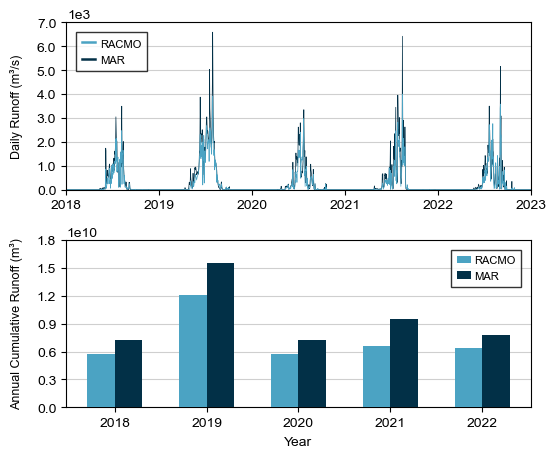

In [57]:
# INITIALISE A FIGURE WITH TWO SUBPLOTS AND GRID LINES SHOWN
plt.rcParams["font.family"] = "Arial"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))
plt.subplots_adjust(hspace=0.3) 
ax1.grid(axis='y', alpha=0.6, zorder=0)
ax2.grid(axis='y', alpha=0.6, zorder=0)
bar_width = 0.3

# # PLOT 1 - DAILY RUNOFF (2018-2023) FROM RACMO AND MAR # # 
ax1.plot(mar_discharge_timeseries['time'], mar_discharge_timeseries.values/1000, label='MAR', linewidth=0.5, color='#023047')
ax1.plot(racmo_discharge_timeseries['time'], racmo_discharge_timeseries.values/1000, label='RACMO', linewidth=0.5, color='#4ba3c3')

ax1.set_ylim(0, 7)
y_ticks = np.arange(0, 7 + 1, 1)
y_ticks_with_decimal = [f'{val:.1f}' for val in y_ticks]
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_ticks_with_decimal)
ax1.annotate("1e3", xy=(0.0025, 1.025), xycoords="axes fraction", fontsize=10, color="black")
ax1.set_ylabel('Daily Runoff (m³/s)', labelpad=10, fontsize=9)

min_x_value = pd.to_datetime('2018-01-01', format='%Y-%m-%d')
max_x_value = pd.to_datetime('2023-01-01', format='%Y-%m-%d')
ax1.set_xlim(min_x_value, max_x_value)

handles, labels = ax1.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
ax1.legend(handles, labels, handlelength=1.2, handleheight=1, handletextpad=0.5, frameon=True, borderpad=0.5, borderaxespad=0.9, markerscale=4, fontsize=8, fancybox=False)
for line in ax1.get_legend().get_lines():
    line.set_linewidth(1.8)
ax1.get_legend().get_frame().set_edgecolor('black')
ax1.get_legend().get_frame().set_linewidth(1)

# # PLOT 2 - ANNUAL CUMULATIVE RUNOFF (2018-2023) FROM RACMO AND MAR # # 
years = [2018, 2019, 2020, 2021, 2022]
racmo_positions = np.arange(len(years))
ax2.bar(racmo_positions - bar_width / 2, racmo_cumulative_volume_yearly, width=bar_width, color='#4ba3c3', zorder=20, label='RACMO')
mar_positions = np.arange(len(years))
ax2.bar(mar_positions + bar_width / 2, mar_cumulative_volume_yearly, width=bar_width, zorder=20, color='#023047', label='MAR')

ax2.set_ylim(0, 1.8e10)
ax2.set_yticks(np.arange(0, 1.8e10 + 2e9, 3e9))
ax2.set_ylabel('Annual Cumulative Runoff (m³)', labelpad=10, fontsize=9)
ax2.set_xticks(mar_positions)
ax2.set_xticklabels(years)
ax2.set_xlabel('Year', labelpad=5, fontsize=10)
ax2.tick_params(labelsize=10)

legend = ax2.legend(handlelength=1.3, handletextpad=0.25, frameon=True, borderpad=0.5, borderaxespad=0.9, markerscale=1, fontsize=8, fancybox=False)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)
